<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/err/3.ML_classifier_averaging_3_day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification (with class labels)
***

# Import

In [75]:
import warnings
warnings.filterwarnings('ignore')

In [76]:
!pip install vecstack==0.4.0 -q
!pip install pyotp --q
!pip install smartapi-python==1.4.1 --q
!pip install logzero --q

In [77]:
#!pip install pandas-ta -q
#==0.2.45b

In [78]:
import warnings
warnings.filterwarnings('ignore')

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from xgboost import XGBClassifier
from vecstack import stacking
import duckdb
import numpy as np
import pandas as pd
#import pandas_ta as ta
from pandas_datareader import data as pdr
START = "2019-01-01"  #yyyy-mm-dd
END = '2024-06-30' #2022-05-13 #2022-05-02
START_testing='2024-07-20'

In [80]:
# package import statement
from SmartApi import SmartConnect #or from SmartApi.smartConnect import SmartConnect
import pyotp
from logzero import logger
import time
import os
import urllib
import json
import pandas as pd
import datetime as dt

api_key = 'xOHnB7MG'
username = 'M55123447'
pwd = '1471'
smartApi = SmartConnect(api_key)
try:
    token = "GJZACUQI2TTAIBHBA34XNFJURQ"
    totp = pyotp.TOTP(token).now()
except Exception as e:
    logger.error("Invalid Token: The provided token is not valid.")
    raise e

correlation_id = "abcde"
data = smartApi.generateSession(username, pwd, totp)

if data['status'] == False:
    logger.error(data)

else:
    # login api call
    # logger.info(f"You Credentials: {data}")
    authToken = data['data']['jwtToken']
    refreshToken = data['data']['refreshToken']
    # fetch the feedtoken
    feedToken = smartApi.getfeedToken()
    # fetch User Profile
    res = smartApi.getProfile(refreshToken)
    smartApi.generateToken(refreshToken)
    res=res['data']['exchanges']


In [81]:
#Download Nifty50 Index Data
params = {
           "exchange": "NSE",
           "symboltoken": '99926000',
           "interval": "ONE_DAY",
           "fromdate": (dt.datetime(2019, 3, 7).strftime('%Y-%m-%d %H:%M')),
           "todate": (dt.datetime.today().strftime('%Y-%m-%d %H:%M'))
         }
nifty_data = smartApi.getCandleData(params)
nifty_data_format= pd.DataFrame(nifty_data["data"],
                               columns = ["Date","Open","High","Low","Close","Volume"])
nifty_data_format.set_index("Date",inplace=True)
nifty_data_format.index = pd.to_datetime(nifty_data_format.index)
nifty_data_format.index = nifty_data_format.index.tz_localize(None)

In [82]:
nifty_data_format.head(2)

,Open,High,Low,Close,Volume
Date,,,,,
2019-12-02,12137.05,12137.15,12023.7,12048.2,0
2019-12-03,12067.65,12068.60,11956.4,11994.2,0


In [83]:
'''
# Path to your DuckDB database file
db_path = "nifty50_data.duckdb"

# Connect to DuckDB
con = duckdb.connect(db_path)

# Fetch table names
tables = con.execute("SHOW TABLES").fetchdf()

if tables.empty:
    print("No tables found in the database.")
else:
    # Get the first table name
    first_table = tables.iloc[0, 0]
    print(f"Using table: {first_table}")

    # Fetch the table data into a Pandas DataFrame
    df = con.execute(f"SELECT * FROM {first_table}").fetchdf()

    # Save DataFrame to a CSV file
    csv_path = "nifty50_data.csv"
    df.to_csv(csv_path, index=False)

    print(f"Table '{first_table}' exported to {csv_path}")

# Close connection
con.close()
'''

'\n# Path to your DuckDB database file\ndb_path = "nifty50_data.duckdb"\n\n# Connect to DuckDB\ncon = duckdb.connect(db_path)\n\n# Fetch table names\ntables = con.execute("SHOW TABLES").fetchdf()\n\nif tables.empty:\n    print("No tables found in the database.")\nelse:\n    # Get the first table name\n    first_table = tables.iloc[0, 0]\n    print(f"Using table: {first_table}")\n\n    # Fetch the table data into a Pandas DataFrame\n    df = con.execute(f"SELECT * FROM {first_table}").fetchdf()\n\n    # Save DataFrame to a CSV file\n    csv_path = "nifty50_data.csv"\n    df.to_csv(csv_path, index=False)\n\n    print(f"Table \'{first_table}\' exported to {csv_path}")\n\n# Close connection\ncon.close()\n'

In [84]:
trend_decider ='percentchange' #'percentchange' #'impulse' # 'sma'#'long' # percentchange
period=3
days_out=3
dictionary_bull={True:1, False:1}#{True:0.75, False:0.5}
dictionary_bear ={True:1,False:1}# {True:3,False:0.5}

In [85]:
def calculate_technical_indicators(df, fast_macd=6, slow_macd=12, signal_macd=4, vortex_length=4, aroon_length=4, rsi_length=4):
    """
    Calculates and appends technical indicators to a DataFrame using only NumPy and Pandas.

    Args:
        df (pd.DataFrame): DataFrame with columns ['High', 'Low', 'Close'].
        fast_macd (int): Fast EMA period for MACD.
        slow_macd (int): Slow EMA period for MACD.
        signal_macd (int): Signal EMA period for MACD.
        vortex_length (int): Period for Vortex Indicator.
        aroon_length (int): Period for Aroon Indicator.
        rsi_length (int): Period for RSI.

    Returns:
        pd.DataFrame: DataFrame with new technical indicators.
    """

    def ema(series, span):
        return series.ewm(span=span, adjust=False).mean()

    def calc_macd(close, fast, slow, signal):
        macd_line = ema(close, fast) - ema(close, slow)
        signal_line = ema(macd_line, signal)
        hist = macd_line - signal_line
        return macd_line, signal_line, hist

    def calc_vortex(high, low, close, length):
        tr = pd.concat([
            high - low,
            (high - close.shift(1)).abs(),
            (low - close.shift(1)).abs()
        ], axis=1).max(axis=1)

        vm_plus = (high - low.shift(1)).abs()
        vm_minus = (low - high.shift(1)).abs()

        tr_sum = tr.rolling(length).sum()
        vm_plus_sum = vm_plus.rolling(length).sum()
        vm_minus_sum = vm_minus.rolling(length).sum()

        vi_plus = vm_plus_sum / tr_sum
        vi_minus = vm_minus_sum / tr_sum

        return vi_plus, vi_minus

    def calc_aroon(high, low, length):
        aroon_up = 100 * high.rolling(length + 1).apply(lambda x: (length - x.argmax()) / length, raw=True)
        aroon_down = 100 * low.rolling(length + 1).apply(lambda x: (length - x.argmin()) / length, raw=True)
        return aroon_up, aroon_down

    def calc_rsi(close, length):
        delta = close.diff()

        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)

        avg_gain = gain.rolling(length).mean()
        avg_loss = loss.rolling(length).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi


    for t in [1.0, 0.75, 0.5, 0.25]:
        f_macd = max(1, int(fast_macd * t))
        s_macd = max(1, int(slow_macd * t))
        sig_macd = max(1, int(signal_macd * t))
        v_len = max(1, int(vortex_length * t))
        a_len = max(1, int(aroon_length * t))
        r_len = max(1, int(rsi_length * t))

        # MACD
        macd_line, signal_line, hist = calc_macd(df['Close'], f_macd, s_macd, sig_macd)
        df[f'MACD_{f_macd}_{s_macd}_{sig_macd}'] = macd_line
        df[f'MACD_signal_{f_macd}_{s_macd}_{sig_macd}'] = signal_line
        df[f'MACD_hist_{f_macd}_{s_macd}_{sig_macd}'] = hist

        # Vortex
        vi_plus, vi_minus = calc_vortex(df['High'], df['Low'], df['Close'], v_len)
        df[f'VI+_{v_len}'] = vi_plus
        df[f'VI-_{v_len}'] = vi_minus

        # Aroon
        aroon_up, aroon_down = calc_aroon(df['High'], df['Low'], a_len)
        df[f'Aroon_Up_{a_len}'] = aroon_up
        df[f'Aroon_Down_{a_len}'] = aroon_down

        # RSI
        rsi = calc_rsi(df['Close'], r_len)
        df[f'RSI_{r_len}'] = rsi

    return df


In [86]:
def calculate_recent_price_action_features(df):
    """
    Calculate recent price action features for a given DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame with 'Date' as index and 'Close', 'Open', 'High', 'Low' columns

    Returns:
    pd.DataFrame: DataFrame with additional columns for recent price action features
    """

    # Ensure the DataFrame is sorted by date
    df = df.sort_index()

    # 1. Previous day's return
    df['prev_day_return'] = df['Close'].pct_change()

    # 2. Weekly return (5 trading days)
    df['weekly_return'] = df['Close'].pct_change(periods=5)

    # 3. Monthly return (21 trading days)
    df['monthly_return'] = df['Close'].pct_change(periods=21)

    # 4. Price momentum (3-day, 5-day, 10-day)
    for period in [2,3,4,5,7,10]:
        df[f'momentum_{period}d'] = df['Close'].pct_change(periods=period)

    # 5. Gap
    df['gap'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)

    # 6. Intraday price range
    df['intraday_range'] = (df['High'] - df['Low']) / df['Close']

    # 7. Distance from moving averages (5-day, 10-day MA)
    for period in [2,3,4,5,10]:
        ma = df['Close'].rolling(window=period).mean()
        df[f'dist_from_ma_{period}d'] = (df['Close'] - ma) / ma

    # 8. Recent highs and lows (5-day window)
    df['near_high_5d'] = df['Close'] >= df['High'].rolling(window=5).max()
    df['near_low_5d'] = df['Close'] <= df['Low'].rolling(window=5).min()
    df['near_high_3d'] = df['Close'] >= df['High'].rolling(window=3).max()
    df['near_low_3d'] = df['Close'] <= df['Low'].rolling(window=3).min()
    df['near_high_2d'] = df['Close'] >= df['High'].rolling(window=2).max()
    df['near_low_2d'] = df['Close'] <= df['Low'].rolling(window=2).min()
    return df

# Prepare data

In [87]:
nifty_data_format = nifty_data_format.drop(columns=["Volume"])


In [88]:
nifty = nifty_data_format.iloc[:-150]  # All data except the last 150 rows
nifty_test = nifty_data_format.iloc[-150:]  # Last 150 rows

In [89]:
nifty.head(2)

,Open,High,Low,Close
Date,,,,
2019-12-02,12137.05,12137.15,12023.7,12048.2
2019-12-03,12067.65,12068.60,11956.4,11994.2


In [90]:
nifty=calculate_technical_indicators(nifty)
nifty=calculate_recent_price_action_features(nifty)

In [91]:
price_data = nifty.copy()

In [92]:
price_data.describe()

,Open,High,Low,Close,MACD_6_12_4,MACD_signal_6_12_4,MACD_hist_6_12_4,VI+_4,VI-_4,Aroon_Up_4,...,momentum_5d,momentum_7d,momentum_10d,gap,intraday_range,dist_from_ma_2d,dist_from_ma_3d,dist_from_ma_4d,dist_from_ma_5d,dist_from_ma_10d
count,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1206.000000,1206.000000,1206.000000,...,1205.000000,1203.000000,1200.000000,1209.000000,1210.000000,1209.000000,1208.000000,1207.000000,1206.000000,1201.000000
mean,16957.070785,17037.788430,16848.659339,16946.896942,33.022422,33.210102,-0.187680,1.028426,0.848298,39.365672,...,0.003387,0.004806,0.007015,0.001312,0.012034,0.000301,0.000613,0.000925,0.001240,0.002871
std,4027.443578,4028.794334,4028.480051,4030.231836,121.291713,115.142001,29.117648,0.328929,0.306803,39.530331,...,0.026038,0.031451,0.038349,0.007576,0.009883,0.006093,0.008813,0.010967,0.012822,0.020416
min,7735.150000,8036.950000,7511.100000,7610.250000,-709.205729,-672.957672,-116.006600,0.192168,0.141430,0.000000,...,-0.190239,-0.229370,-0.307495,-0.091448,0.001895,-0.069407,-0.072643,-0.079997,-0.095203,-0.170161
25%,14574.025000,14656.625000,14441.650000,14563.800000,-31.269595,-29.620971,-16.794642,0.783312,0.610811,0.000000,...,-0.008651,-0.008823,-0.009566,-0.001077,0.006994,-0.002099,-0.003342,-0.003995,-0.004379,-0.005595
50%,17374.375000,17437.525000,17241.525000,17353.775000,43.885265,45.659970,0.374426,1.034358,0.844918,25.000000,...,0.005482,0.007336,0.009556,0.001735,0.009593,0.000641,0.001356,0.001906,0.002499,0.004941
75%,19364.712500,19423.375000,19286.962500,19345.150000,117.060720,114.478069,17.503782,1.269977,1.076688,75.000000,...,0.017642,0.021698,0.027533,0.004461,0.014018,0.003360,0.005039,0.006483,0.008104,0.013940
max,26248.250000,26277.350000,26151.400000,26216.050000,294.609597,275.758307,124.808889,2.171603,1.714702,100.000000,...,0.105221,0.146336,0.168035,0.044843,0.161147,0.041977,0.051599,0.067815,0.059759,0.069447


In [93]:
features = price_data.columns.tolist()

In [94]:
features

['Open',
 'High',
 'Low',
 'Close',
 'MACD_6_12_4',
 'MACD_signal_6_12_4',
 'MACD_hist_6_12_4',
 'VI+_4',
 'VI-_4',
 'Aroon_Up_4',
 'Aroon_Down_4',
 'RSI_4',
 'MACD_4_9_3',
 'MACD_signal_4_9_3',
 'MACD_hist_4_9_3',
 'VI+_3',
 'VI-_3',
 'Aroon_Up_3',
 'Aroon_Down_3',
 'RSI_3',
 'MACD_3_6_2',
 'MACD_signal_3_6_2',
 'MACD_hist_3_6_2',
 'VI+_2',
 'VI-_2',
 'Aroon_Up_2',
 'Aroon_Down_2',
 'RSI_2',
 'MACD_1_3_1',
 'MACD_signal_1_3_1',
 'MACD_hist_1_3_1',
 'VI+_1',
 'VI-_1',
 'Aroon_Up_1',
 'Aroon_Down_1',
 'RSI_1',
 'prev_day_return',
 'weekly_return',
 'monthly_return',
 'momentum_2d',
 'momentum_3d',
 'momentum_4d',
 'momentum_5d',
 'momentum_7d',
 'momentum_10d',
 'gap',
 'intraday_range',
 'dist_from_ma_2d',
 'dist_from_ma_3d',
 'dist_from_ma_4d',
 'dist_from_ma_5d',
 'dist_from_ma_10d',
 'near_high_5d',
 'near_low_5d',
 'near_high_3d',
 'near_low_3d',
 'near_high_2d',
 'near_low_2d']

#####df = df.assign(flag=df['apm'].gt(df['apm'].shift()))

In [95]:
if trend_decider=='impulse':
  price_data=price_data.assign(Flag=(price_data['MACDh_12_26_9'].lt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].lt(price_data['ADV_13'].shift())))
elif trend_decider=='sma':
  price_data= price_data.assign(Flag=price_data['ADV_50'].lt(price_data['ADV_50'].shift()))
elif trend_decider=='long':
  price_data= price_data.assign(Flag=price_data['ADV_50'].lt(price_data['ADV_50'].shift(period)))
elif trend_decider=='percentchange':
  close_groups = price_data['Close'].transform(lambda x : np.sign(x.diff(days_out)))
  price_data['Flag'] = close_groups

# Calculate the conditions separately
condition1 = price_data['MACDh_12_26_9'] > price_data['MACDh_12_26_9'].shift()
condition2 = price_data['ADV_13'] > price_data['ADV_13'].shift()

# Create the Strength_Flag_dummy column
price_data['Strength_Flag_dummy'] = condition1 & condition2


In [96]:
#price_data=price_data.assign(Strength_Flag_dummy=(price_data['MACDh_12_26_9'].gt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].gt(price_data['ADV_13'].shift())))

In [97]:
#price_data=price_data.assign(Strength_Flag_dum=(price_data['MACDh_12_26_9'].lt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].lt(price_data['ADV_13'].shift())))

In [98]:
all_nan_columns = price_data.columns[price_data.isna().all()]
print(all_nan_columns)

Index([], dtype='object')


In [99]:
price_data.dropna(inplace=True)

In [100]:
#price_data.Strength_Flag_dummy.value_counts()

In [101]:
#price_data.Strength_Flag_dummy = price_data.Strength_Flag_dummy.replace(dictionary_bull)

In [102]:
#price_data.Strength_Flag_dum.value_counts()

In [103]:
#price_data.Strength_Flag_dum = price_data.Strength_Flag_dum.replace(dictionary_bear)

In [104]:
#price_data['Strength_Flag']=price_data.Strength_Flag_dum+price_data.Strength_Flag_dummy

In [105]:
X_Cols = price_data[features]
Y_Cols = price_data['Flag']
samp_train= int(len(price_data)*.75) -100
samp_test= samp_train+100
X_train = X_Cols[:samp_train]
X_test = X_Cols[samp_test:]
y_train = Y_Cols[:samp_train]
y_test = Y_Cols[samp_test:]

In [106]:
len(price_data)

1188

# Initialize 1st level models

In [107]:
#sample_w=price_data[:samp_train].Strength_Flag.values

In [108]:
models_L1 = [
    LogisticRegression(max_iter=12000),
    svm.SVC(kernel='linear'),
    ExtraTreesClassifier(random_state=0, n_jobs=-1,
                         n_estimators=100, max_depth=3,class_weight='balanced' ),

    RandomForestClassifier(random_state=0, n_jobs=-1,
                           n_estimators=500, max_depth=3,class_weight='balanced'),

    LDA(solver='svd', shrinkage=None, priors=None, n_components=None,
        store_covariance=False, tol=0.0001, covariance_estimator=None),

]

In [109]:
'''XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,sample_weight=sample_w,
                  n_estimators=100, max_depth=3)'''

'XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,sample_weight=sample_w,\n                  n_estimators=100, max_depth=3)'

In [110]:
model_L1_0 = models_L1[0]
_ = model_L1_0.fit(X_train, y_train)
# save model in file if you need

model_L1_1 = models_L1[1]
_ = model_L1_1.fit(X_train, y_train)#sample_weight=sample_w
# save model in file if you need

model_L1_2 = models_L1[2]
_ = model_L1_2.fit(X_train, y_train)#,sample_weight=sample_w
# save model in file if you need

model_L1_3 = models_L1[3]
_ = model_L1_3.fit(X_train, y_train)
# save model in file if you need
model_L1_4 = models_L1[4]
_ = model_L1_4.fit(X_train, y_train)
# save model in file if you need

# save model in file if you need



In [111]:
model_L1_3.feature_importances_

array([1.14422196e-04, 1.88098339e-04, 9.72599290e-05, 8.99269621e-05,
       7.98929698e-04, 2.18888678e-04, 2.00993844e-02, 3.07088020e-03,
       3.22476698e-03, 5.98722217e-03, 9.48744825e-03, 2.43657371e-02,
       6.94230163e-04, 5.67247846e-04, 2.01256047e-02, 8.70747433e-02,
       5.06540735e-02, 1.50982169e-02, 3.42893154e-02, 1.77802767e-01,
       5.93307413e-03, 2.94864432e-03, 3.94426126e-03, 3.25407246e-02,
       5.49609554e-02, 7.89264445e-03, 9.65419376e-03, 1.28432340e-02,
       2.60720653e-02, 1.37029441e-02, 0.00000000e+00, 2.00838021e-04,
       1.38682557e-03, 4.14912113e-05, 1.79644591e-05, 4.48798956e-04,
       1.77604598e-03, 2.54580840e-03, 4.83218469e-04, 1.07993170e-02,
       1.74841051e-01, 1.53642897e-02, 2.00983431e-03, 5.36848905e-04,
       2.79128323e-04, 1.21221632e-04, 3.60404306e-04, 1.51670947e-03,
       5.44004084e-03, 6.90071660e-02, 7.83357109e-02, 9.94538142e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [112]:
importances = model_L1_3.feature_importances_
data = {'feature_name': features, 'importance': importances*100}
df = pd.DataFrame(data)

In [113]:
df = df.sort_values(by='importance')
print(df)

          feature_name  importance
30     MACD_hist_1_3_1    0.000000
56        near_high_2d    0.000000
55         near_low_3d    0.000000
54        near_high_3d    0.000000
57         near_low_2d    0.000000
52        near_high_5d    0.000000
53         near_low_5d    0.000000
34        Aroon_Down_1    0.001796
33          Aroon_Up_1    0.004149
3                Close    0.008993
2                  Low    0.009726
0                 Open    0.011442
45                 gap    0.012122
1                 High    0.018810
31               VI+_1    0.020084
5   MACD_signal_6_12_4    0.021889
44        momentum_10d    0.027913
46      intraday_range    0.036040
35               RSI_1    0.044880
38      monthly_return    0.048322
43         momentum_7d    0.053685
13   MACD_signal_4_9_3    0.056725
12          MACD_4_9_3    0.069423
4          MACD_6_12_4    0.079893
32               VI-_1    0.138683
47     dist_from_ma_2d    0.151671
36     prev_day_return    0.177605
42         momentum_

# Perform stacking

In [114]:
S_train, S_test = stacking(models_L1,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need
                                                       #     regression - set to True)
                           mode='oof',                 # mode: oof for train set, predict test
                                                       #mode='oof_pred_bag'(for training) and oof for inference
                                                      #     set in each fold and vote
                           needs_proba=False,          # predict class labels (if you need
                                                       #     probabilities - set to True)
                           save_dir=None,              # do not save result and log (to save
                                                       #     in current dir - set to '.')
                           metric=accuracy_score,      # metric: callable
                           n_folds=4,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=False,               # shuffle the data
                           random_state=None,             # ensure reproducibility
                           verbose=2)                  # print all info

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof]
n_models:     [5]

model  0:     [LogisticRegression]
    fold  0:  [0.92929293]
    fold  1:  [0.97474747]
    fold  2:  [0.97979798]
    fold  3:  [0.97969543]
    ----
    MEAN:     [0.96588345] + [0.02122394]
    FULL:     [0.96586599]

model  1:     [SVC]
    fold  0:  [0.93434343]
    fold  1:  [0.96969697]
    fold  2:  [0.97979798]
    fold  3:  [0.97461929]
    ----
    MEAN:     [0.96461442] + [0.01783818]
    FULL:     [0.96460177]

model  2:     [ExtraTreesClassifier]
    fold  0:  [0.93434343]
    fold  1:  [0.94444444]
    fold  2:  [0.93434343]
    fold  3:  [0.89847716]
    ----
    MEAN:     [0.92790212] + [0.01748183]
    FULL:     [0.92793932]

model  3:     [RandomForestClassifier]
    fold  0:  [1.00000000]
    fold  1:  [0.99494949]
    fold  2:  [1.00000000]
    fold  3:  [0.99492386]
    ----
    MEAN:     [0.99746834] + [0.00253168]
    FULL:     [0.99747155]

mo

# Look at the result

So now we have OOF from 1st level models and we can build 2nd level model.  
But first let's look at the result.  
We have three 1st level models, so we expect to get three columns in `S_train` and `S_test`.  

In [115]:
# XGboost
model_L1_X = XGBClassifier(learning_rate =0.1,
 n_estimators=100,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 reg_alpha= 0.01,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
# Fit 2nd level model
dummy_train = model_L1_X.fit(X_train,y_train)
# Predict
#y_pred = model_L2.predict(S_test)

# Final prediction score
#print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

# Apply 2nd level model

In [116]:
'''
# Initialize 2nd level model
model_L2 = XGBClassifier(learning_rate =0.1,
 n_estimators=100,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 reg_alpha= 0.01,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
S_train=np.c_[S_train,dummy_train]
# Fit 2nd level model
_ = model_L2.fit(S_train,y_train)
# Predict
y_pred = model_L2.predict(S_test)

# Final prediction score
#print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))
'''

"\n# Initialize 2nd level model\nmodel_L2 = XGBClassifier(learning_rate =0.1,\n n_estimators=100,\n max_depth=3,\n min_child_weight=1,\n gamma=0,\n reg_alpha= 0.01,\n subsample=0.75,\n colsample_bytree=0.75,\n objective= 'binary:logistic',\n nthread=4,\n scale_pos_weight=1,\n seed=27)\nS_train=np.c_[S_train,dummy_train]\n# Fit 2nd level model\n_ = model_L2.fit(S_train,y_train)\n# Predict\ny_pred = model_L2.predict(S_test)\n\n# Final prediction score\n#print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))\n"

# Make Predictions

In [117]:
nifty_test = nifty_test[~nifty_test.index.duplicated(keep='first')]  # Keeps only the first occurrence


In [118]:
nifty_test=calculate_technical_indicators(nifty_test)
nifty_test=calculate_recent_price_action_features(nifty_test)
df = nifty_test.copy()
# I Just need the Close
price_data_new = df.copy()

price_data_new.tail(2)

,Open,High,Low,Close,MACD_6_12_4,MACD_signal_6_12_4,MACD_hist_6_12_4,VI+_4,VI-_4,Aroon_Up_4,...,dist_from_ma_3d,dist_from_ma_4d,dist_from_ma_5d,dist_from_ma_10d,near_high_5d,near_low_5d,near_high_3d,near_low_3d,near_high_2d,near_low_2d
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-21,24744.25,24946.2,24685.35,24813.45,131.785861,158.014023,-26.228162,1.218714,1.194643,100.0,...,-0.000033,-0.002099,-0.003674,0.004689,False,False,False,False,False,False
2025-05-22,24733.95,24737.5,24462.40,24606.30,86.809321,129.532142,-42.722822,0.483732,1.231846,100.0,...,-0.003843,-0.006299,-0.008361,-0.005038,False,False,False,False,False,False


In [119]:
# Group by the `Symbol` column, then grab the `Close` column.
#close_groups = price_data_new['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
#close_groups = close_groups.transform(lambda x : np.sign(x.diff(days_out)))

# add the data to the main dataframe.
#price_data_new['Prediction'] = close_groups
price_data_new = price_data_new.dropna()

X_test_new =price_data_new[features]
#Y_Cols = price_data_new['Prediction']




In [120]:
#[4] Then new test set (X_test_new) comes. We load our 1st level models and predict new test set to get stacked features (S_test_new):
y_pred_L1_0 = model_L1_0.predict(X_test_new)
y_pred_L1_1 = model_L1_1.predict(X_test_new)
y_pred_L1_2 = model_L1_2.predict(X_test_new)
y_pred_L1_3 = model_L1_3.predict(X_test_new)
y_pred_L1_4 = model_L1_4.predict(X_test_new)

#y_pred_l1_6= model_L1_X.predict(X_test_new)
S_test_new = np.c_[y_pred_L1_0, y_pred_L1_1,y_pred_L1_2,y_pred_L1_3,y_pred_L1_4]
#[5] Then we load our 2nd level model and predict S_test_new to get final prediction:

#y_pred_new = model_L2.predict(S_test_new)


In [121]:
S_test_new[-5:]#.sum(axis=1)

array([[ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.]])

In [122]:
y_pred_new_p = S_test_new.sum(axis=1)

In [123]:
y_pred_new_p

array([-5., -5., -5., -5., -5., -5.,  5.,  5.,  5.,  5., -5., -5.,  1.,
        5.,  5.,  5.,  5.,  5., -5., -5., -5.,  5., -3., -5., -5., -5.,
       -5., -5., -5.,  3.,  5., -5., -5., -5.,  5.,  5., -5., -5., -5.,
       -5., -5., -5., -5., -5.,  5.,  3.,  3., -5., -5., -5.,  5., -5.,
       -5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5., -5., -5., -5., -5.,
       -5., -5., -5., -5.,  3., -5., -5., -5., -5., -5., -5., -5., -5.,
        5.,  5.,  5.,  5., -5., -5., -5.,  3.,  5.,  5.,  5.,  5.,  5.,
        5.,  5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5., -5., -3.,  5.,  5.,  5.,  5.,  5.,
        3., -5., -5.,  5.,  5.,  5.,  5.,  5.,  5., -5., -5., -5.])

In [124]:
'''
price_data_new=price_data_new.assign(Strength_Flag_dummy=(price_data_new['MACDh_12_26_9'].gt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].gt(price_data_new['ADV_13'].shift())))
price_data_new=price_data_new.assign(Strength_Flag_dum=(price_data_new['MACDh_12_26_9'].lt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].lt(price_data_new['ADV_13'].shift())))
price_data_new.dropna(inplace=True)
price_data_new.Strength_Flag_dum = price_data_new.Strength_Flag_dum.replace(dictionary_bear)
price_data_new.Strength_Flag_dummy = price_data_new.Strength_Flag_dummy.replace(dictionary_bull)
price_data_new['Strength_Flag']=price_data_new.Strength_Flag_dum+price_data_new.Strength_Flag_dummy
'''

"\nprice_data_new=price_data_new.assign(Strength_Flag_dummy=(price_data_new['MACDh_12_26_9'].gt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].gt(price_data_new['ADV_13'].shift())))\nprice_data_new=price_data_new.assign(Strength_Flag_dum=(price_data_new['MACDh_12_26_9'].lt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].lt(price_data_new['ADV_13'].shift())))\nprice_data_new.dropna(inplace=True)\nprice_data_new.Strength_Flag_dum = price_data_new.Strength_Flag_dum.replace(dictionary_bear)\nprice_data_new.Strength_Flag_dummy = price_data_new.Strength_Flag_dummy.replace(dictionary_bull)\nprice_data_new['Strength_Flag']=price_data_new.Strength_Flag_dum+price_data_new.Strength_Flag_dummy\n"

In [125]:
#price_data_new.Strength_Flag = price_data_new.Strength_Flag.replace(dictionary)

In [126]:
#price_data_new.tail(2)

In [127]:
'''
if trend_decider !='percentchange':
  #price_data_new.Flag = price_data_new.Flag.replace({True: 0, False: 1})
  y_pred_new=y_pred_new.astype(int)
  indices_one = y_pred_new == 1
  indices_zero = y_pred_new == 0
  y_pred_new[indices_one] = 0 # replacing 1s with 0s
  y_pred_new[indices_zero] = 1 # replacing 0s with 1s
if trend_decider =='percentchange':
  #price_data_new.Flag = np.where(price_data_new.close>price_data_new.close.shift(1),1,-1)
  print('done')
'''

"\nif trend_decider !='percentchange':\n  #price_data_new.Flag = price_data_new.Flag.replace({True: 0, False: 1})\n  y_pred_new=y_pred_new.astype(int)\n  indices_one = y_pred_new == 1\n  indices_zero = y_pred_new == 0\n  y_pred_new[indices_one] = 0 # replacing 1s with 0s\n  y_pred_new[indices_zero] = 1 # replacing 0s with 1s\nif trend_decider =='percentchange':\n  #price_data_new.Flag = np.where(price_data_new.close>price_data_new.close.shift(1),1,-1)\n  print('done')\n"

In [128]:
#actuals=price_data_new['Flag'].dropna()
#actuals.value_counts()

rapida = 18
lenta = 26
stdv = 0.5
df['fast'] =df['Close'].ewm(span=rapida).mean()
df['slow'] =df['Close'].ewm(span=lenta).mean()
df['bband']= df['fast']-df['slow']
df['avg'] = df['bband'].rolling(window=9).mean()
df['Sdev'] = df['bband'].rolling(window=9).std()
df['Upper Band'] = df['avg'] + (df['Sdev'] *stdv)
df['Lower Band'] = df['avg'] - (df['Sdev'] *stdv)

In [129]:
rapida = 2*1.2
lenta = 6*1.2
stdv =0.8
df['fast'] =df['Close'].ewm(span=rapida).mean()
df['slow'] =df['Close'].ewm(span=lenta).mean()
df['bband']= df['fast']-df['slow']
df['avg'] = df['bband'].rolling(window=10).mean()
df['Sdev'] = df['bband'].rolling(window=12).std()
df['Upper Band'] = df['avg'] + (df['Sdev'] *stdv)
df['Lower Band'] = df['avg'] - (df['Sdev'] *stdv)
df['spread'] = df['bband'] - df['Lower Band']
df['spread_1'] = -(df['bband'] - df['Upper Band'])

In [130]:
df['dnsignal']=np.where(df['spread_1']>df['spread_1'].rolling(window=30).mean(),-1,0)
df['upsignal']=np.where(df['spread']>df['spread'].rolling(window=30).mean(),1,0)

In [131]:
buy= np.where(y_pred_new_p>=0)
sell= np.where(y_pred_new_p<0) #0 if impulse !!!


In [132]:
price_data_new.shape,y_pred_new_p.shape

((129, 58), (129,))

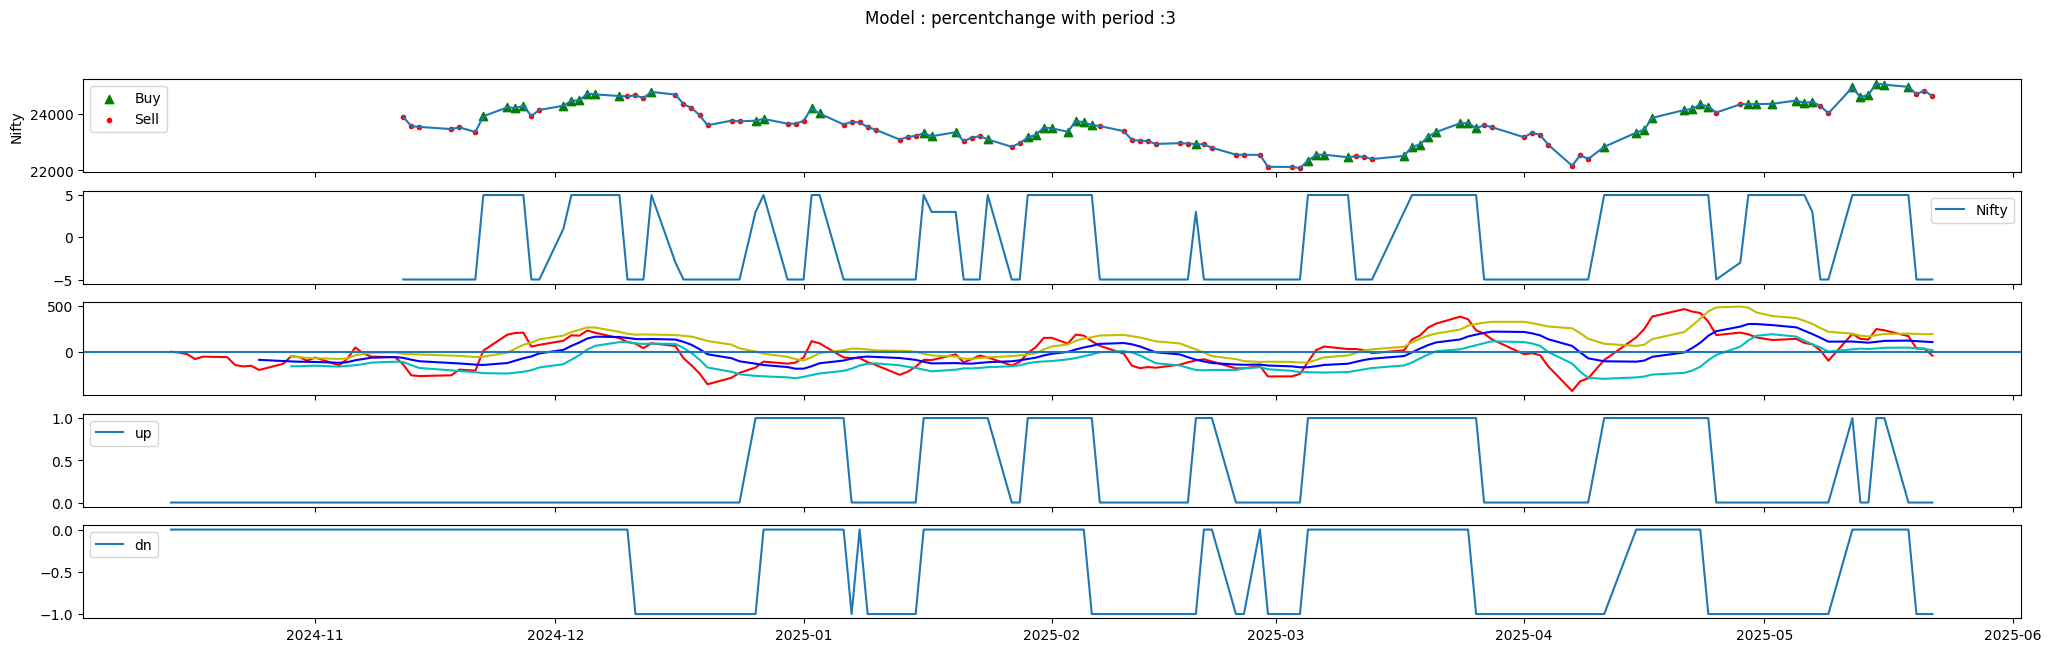

In [133]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5,1, figsize=(25,7),sharex=True)
ax[0].plot(price_data_new.loc[:, :].index, price_data_new.loc[:, 'Close'])
ax[1].plot(price_data_new.loc[:, :].index, y_pred_new_p, label='Nifty')
ax[0].scatter(price_data_new.iloc[buy].index,price_data_new.iloc[buy].Close,marker='^',label='Buy',color='g')
ax[0].scatter(price_data_new.iloc[sell].index,price_data_new.iloc[sell].Close,marker='.',label='Sell',color='r')
ax[2].plot(df[['bband']][:],color='r')
ax[2].plot(df[['avg',]][:],color='b')
ax[2].plot(df[['Upper Band',]][:],color='y')
ax[2].plot(df[['Lower Band']][:],color='c')
ax[2].axhline(y=0)
ax[3].plot(df['upsignal'] , label='up')
ax[4].plot(df['dnsignal'],label='dn')
ax[0].legend(loc='upper left')
ax[3].legend(loc='upper left')
ax[4].legend(loc='upper left')
ax[0].set_ylabel('Nifty')
ax[1].legend('ML Signal')
ax[1].legend(loc='best')
fig.suptitle('Model : '+ trend_decider +' with period :' + str(period))
plt.savefig('ml.png')
plt.show()


In [134]:
price_data_new.to_csv('result.csv')

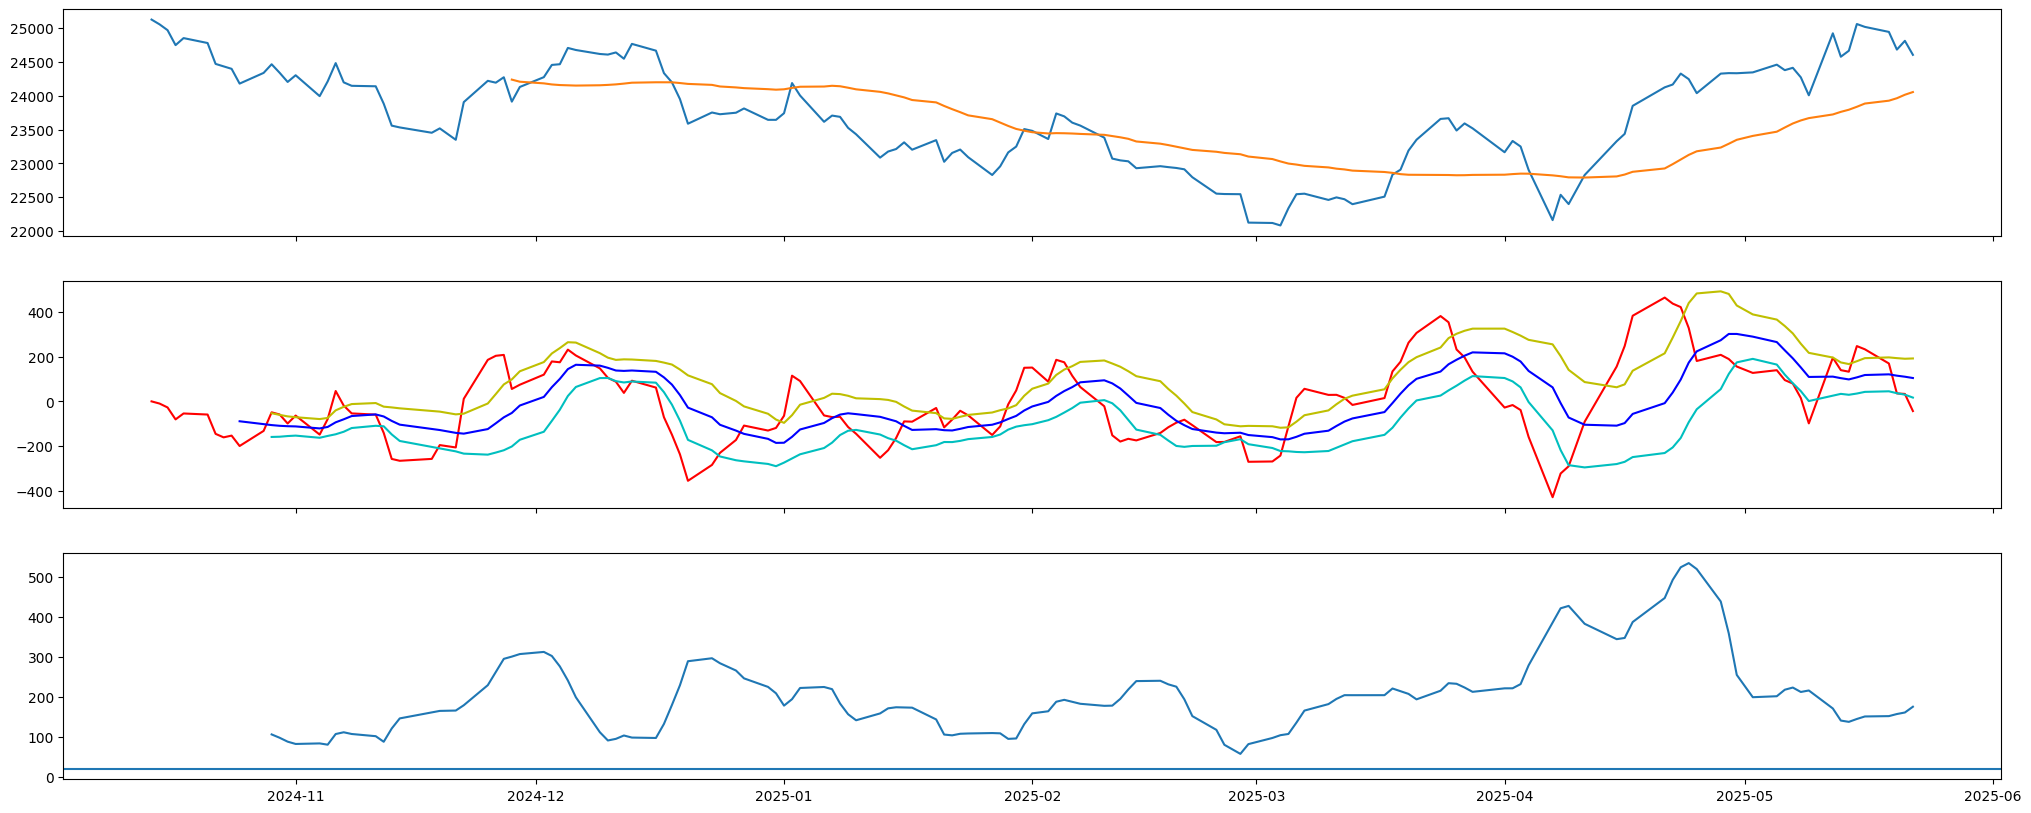

In [135]:
fig, ax = plt.subplots(3,1, figsize=(25,10),sharex=True)
ax[0].plot(df.loc[:, 'Close'])
ax[0].plot(df.loc[:,'Close'].rolling(window=32).mean())
ax[1].plot(df[['bband']][:],color='r')
ax[1].plot(df[['avg',]][:],color='b')
ax[1].plot(df[['Upper Band',]][:],color='y')
ax[1].plot(df[['Lower Band']][:],color='c')
ax[2].plot(df['Upper Band']-df['Lower Band'])
ax[2].axhline(y=20)
plt.show()

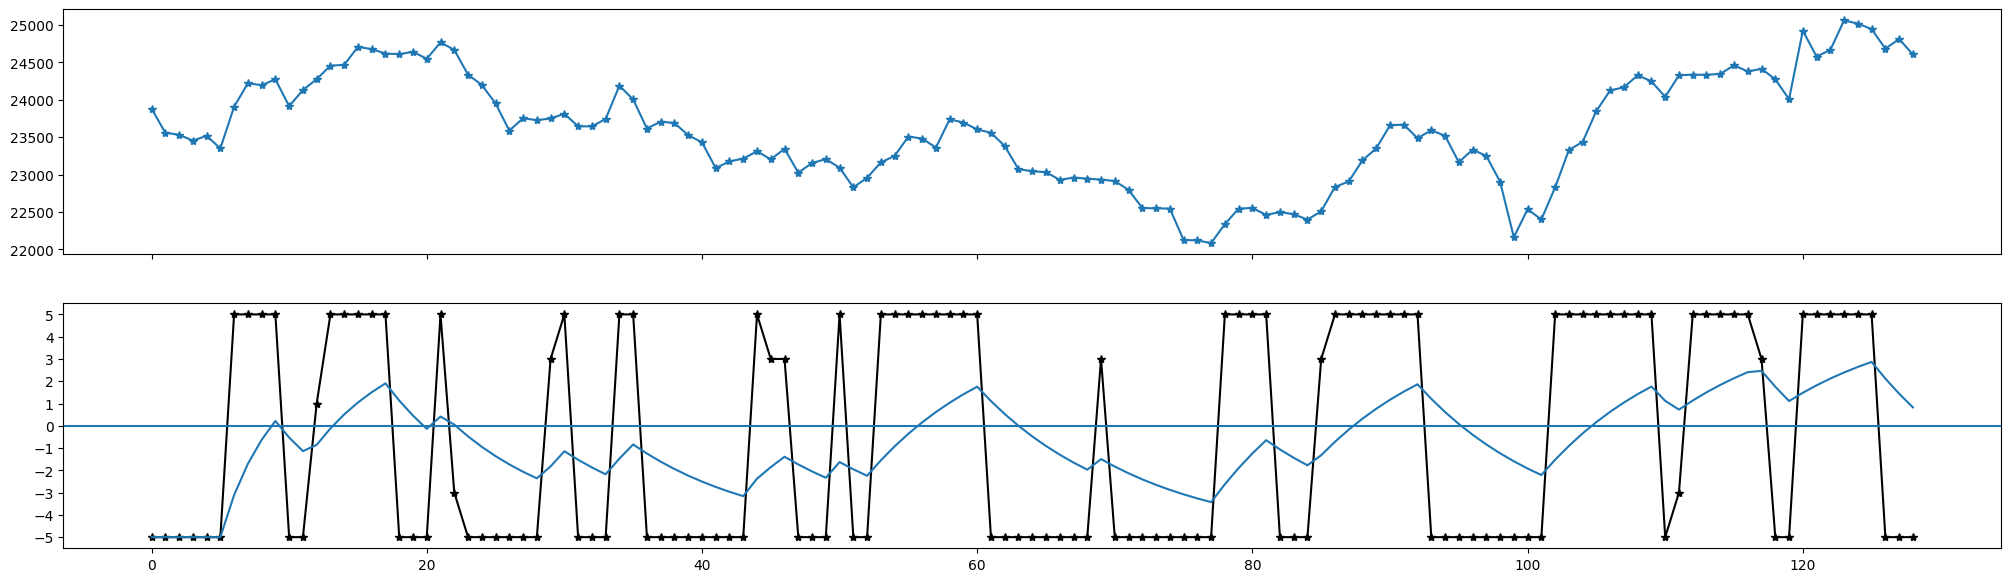

In [136]:
fig, ax = plt.subplots(2,1, figsize=(25,7),sharex=True)
ax[0].plot(pd.Series(price_data_new['Close'].values,),'*-')
rng = np.arange(-9,8,1)
ax[1].set_yticks(rng)
ax[1].plot(pd.Series(S_test_new[:].sum(axis=1)),'k*-')
ax[1].plot(pd.Series(S_test_new[:].sum(axis=1)).ewm(span=20).mean())
ax[1].axhline(y=0);

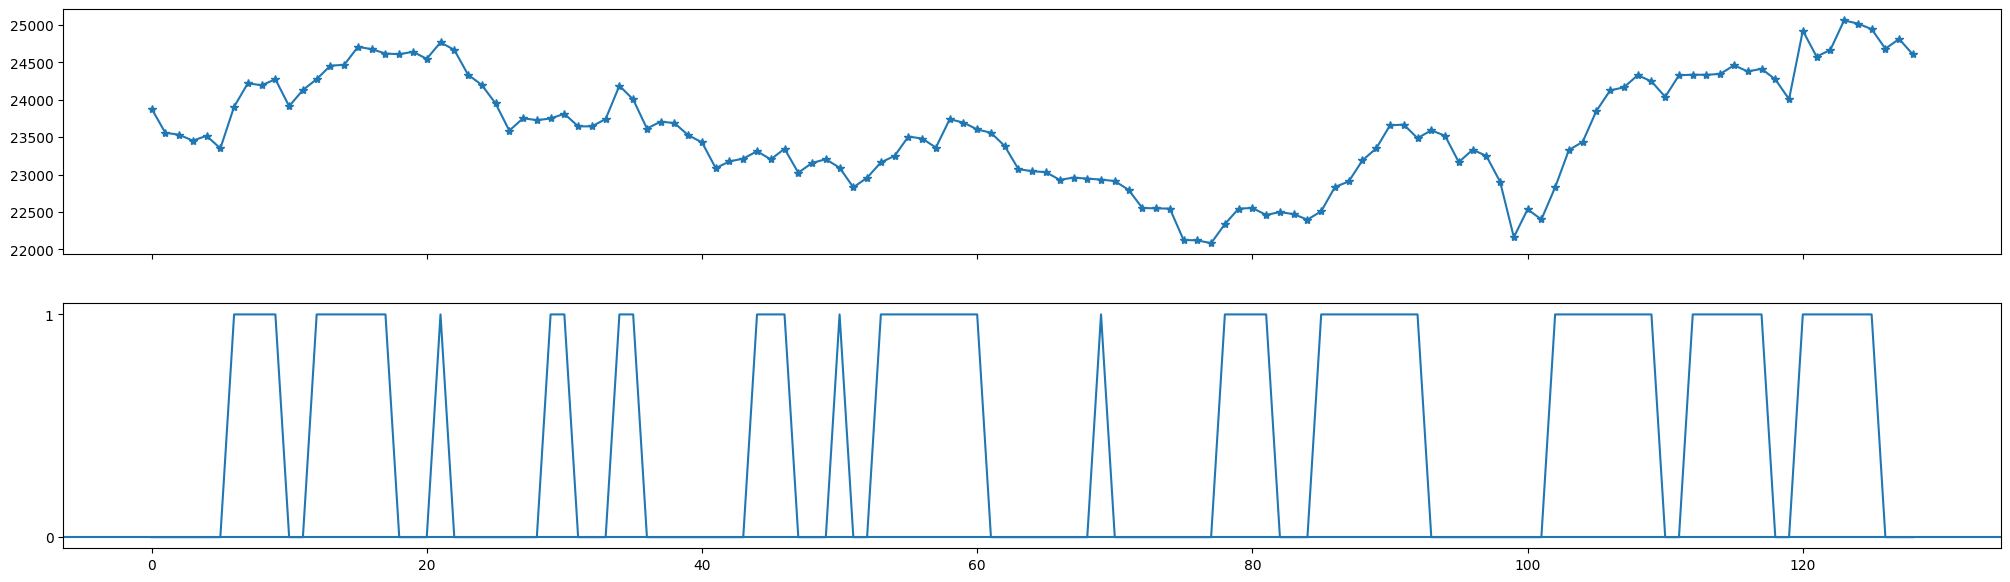

In [137]:
fig, ax = plt.subplots(2,1, figsize=(25,7),sharex=True)
ax[0].plot(pd.Series(price_data_new['Close'].values,),'*-')
rng = np.arange(-9,8,1)
ax[1].set_yticks(rng)
ax[1].plot(pd.Series(np.where(S_test_new.sum(axis=1)>0,1,0)))
#ax[1].plot(pd.Series(S_test_new[:].sum(axis=1)).ewm(span=20).mean())
ax[1].axhline(y=0);

In [138]:
price_data_new['Position']=(np.where(S_test_new.sum(axis=1)>0,1,0))
# Calculate returns based on NEXT DAY's Open price
price_data_new['Returns'] = (price_data_new['Open'].shift(-2) / price_data_new['Close'].shift(-1) - 1) * price_data_new['Position']


In [139]:
price_data_new['Open'].shift(-1).tail(5)

,Open
Date,
2025-05-16,25005.35
2025-05-19,24996.20
2025-05-20,24744.25
2025-05-21,24733.95
2025-05-22,NaN


In [140]:
price_data_new['Close'].tail(5)

,Close
Date,
2025-05-16,25019.80
2025-05-19,24945.45
2025-05-20,24683.90
2025-05-21,24813.45
2025-05-22,24606.30


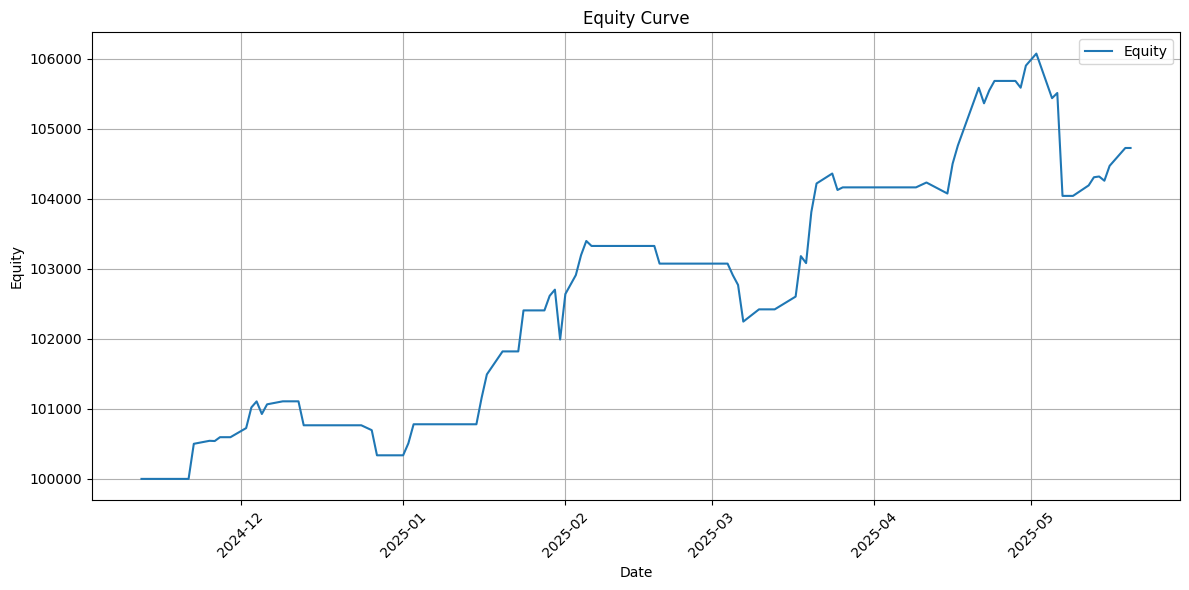

In [141]:
initial_capital = 100000
price_data_new['Equity'] = initial_capital * (1 + price_data_new['Returns']).cumprod()
# Plot the Equity Curve
plt.figure(figsize=(12, 6))  # Adjust figure size as desired
plt.plot(price_data_new.index, price_data_new['Equity'], label='Equity')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Equity Curve')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

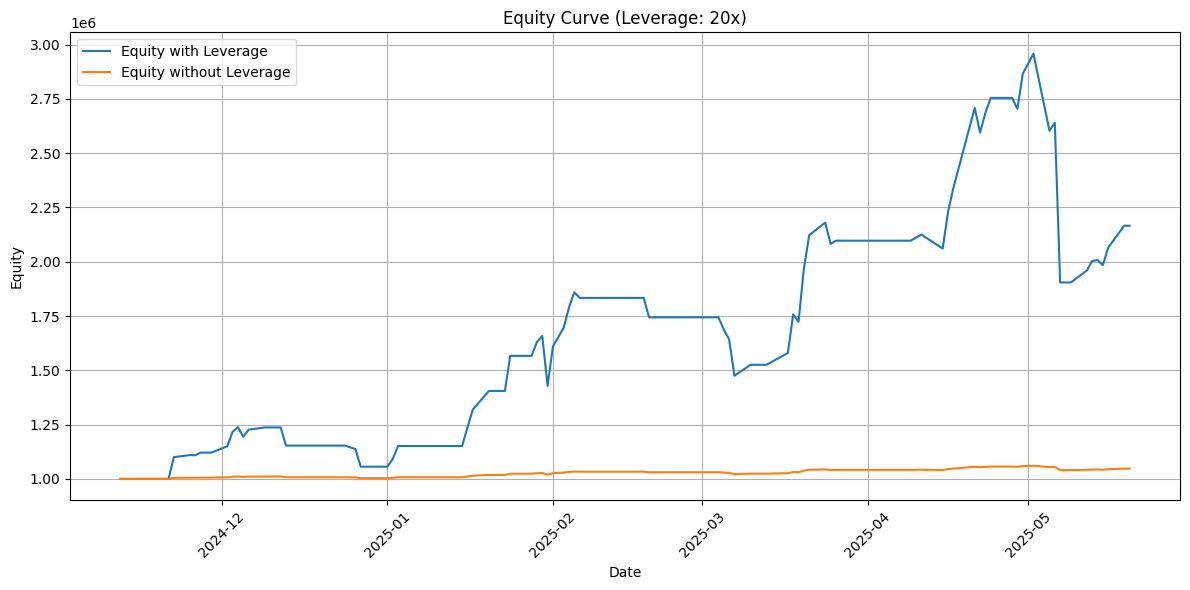

In [142]:

# Assuming price_data_new is already defined
initial_capital = 1000000
leverage = 20 # Set your desired leverage here

# Calculate leveraged returns
price_data_new['Leveraged_Returns'] = price_data_new['Returns'] * leverage

# Calculate equity with leverage
price_data_new['Equity'] = initial_capital * (1 + price_data_new['Leveraged_Returns']).cumprod()

# Calculate equity without leverage for comparison
price_data_new['Equity_No_Leverage'] = initial_capital * (1 + price_data_new['Returns']).cumprod()

# Plot the Equity Curves
plt.figure(figsize=(12, 6))
plt.plot(price_data_new.index, price_data_new['Equity'], label='Equity with Leverage')
plt.plot(price_data_new.index, price_data_new['Equity_No_Leverage'], label='Equity without Leverage')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title(f'Equity Curve (Leverage: {leverage}x)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [143]:
def calculate_metrics(returns_series):
    """Calculates various trade metrics.

    Args:
        returns_series (pandas.Series): A Series of daily returns.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """

    annualized_return = (1 + returns_series).prod() ** (252 / len(returns_series)) - 1
    annualized_std = returns_series.std() * np.sqrt(252)

    sharpe_ratio = annualized_return / annualized_std

    cumulative_returns = (1 + returns_series).cumprod()
    cumulative_max = cumulative_returns.cummax()
    drawdowns = cumulative_returns / cumulative_max - 1
    max_drawdown = drawdowns.min()
    calmar_ratio = annualized_return / abs(max_drawdown)

    # Calculate CAGR
    start_value = 1  # Initial investment
    end_value = (1 + returns_series).cumprod().iloc[-1]
    num_years = len(returns_series) / 252  # Assuming 252 trading days
    cagr = (end_value / start_value) ** (1 / num_years) - 1

    metrics = {
        'CAGR': cagr,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_std,
        'Sharpe Ratio': sharpe_ratio,
        'Calmar Ratio': calmar_ratio,
        'Max Drawdown': max_drawdown
    }

    return metrics

metrics = calculate_metrics(price_data_new['Returns'])

In [144]:
def calculate_metrics(returns_series, leverage=1, risk_free_rate=7.5):
    """Calculates various trade metrics with leverage.

    Args:
        returns_series (pandas.Series): A Series of daily returns.
        leverage (float): The leverage factor. Default is 1 (no leverage).
        risk_free_rate (float): The risk-free rate. Default is 0.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """

    # Apply leverage to returns
    leveraged_returns = returns_series * leverage

    # Adjust for borrowing cost (simplified)
    borrowing_cost = (leverage - 1) * risk_free_rate / 252  # Daily borrowing cost
    net_leveraged_returns = leveraged_returns - borrowing_cost

    annualized_return = (1 + net_leveraged_returns).prod() ** (252 / len(net_leveraged_returns)) - 1
    annualized_std = net_leveraged_returns.std() * np.sqrt(252)

    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std

    cumulative_returns = (1 + net_leveraged_returns).cumprod()
    cumulative_max = cumulative_returns.cummax()
    drawdowns = cumulative_returns / cumulative_max - 1
    max_drawdown = drawdowns.min()
    calmar_ratio = annualized_return / abs(max_drawdown)

    # Calculate CAGR
    start_value = 1  # Initial investment
    end_value = cumulative_returns.iloc[-1]
    num_years = len(net_leveraged_returns) / 252  # Assuming 252 trading days
    cagr = (end_value / start_value) ** (1 / num_years) - 1

    metrics = {
        'CAGR': cagr,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_std,
        'Sharpe Ratio': sharpe_ratio,
        'Calmar Ratio': calmar_ratio,
        'Max Drawdown': max_drawdown,
        'Leverage': leverage
    }

    return metrics

# Example usage:


In [145]:
metrics = calculate_metrics(price_data_new['Returns'], leverage=20, risk_free_rate=0.06)

In [146]:
for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

CAGR: nan
Annualized Return: 0.4774
Annualized Volatility: 0.7702
Sharpe Ratio: 0.5420
Calmar Ratio: 1.2829
Max Drawdown: -0.3721
Leverage: 20.0000


In [147]:
from sklearn.metrics import classification_report
y_pred=np.sign(np.where(S_test_new.sum(axis=1)==0,1,S_test_new.sum(axis=1)))
y_true=price_data_new['Close'].transform(lambda x : np.sign(x.diff(days_out)))
y_true=y_true.dropna()
y_pred=y_pred[-len(y_true):]
print("Classification Report Averaging")
print(classification_report(y_true, y_pred))

Classification Report Averaging
              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        65
         1.0       1.00      0.98      0.99        61

    accuracy                           0.99       126
   macro avg       0.99      0.99      0.99       126
weighted avg       0.99      0.99      0.99       126



Precision

Downday (-1.0): Your model is correct about 62% of the time when predicting a downday.
Upday (1.0): Your model is very reliable, showing 92% precision in predicting updays.


Recall

Downday (-1.0): Your model identifies 83% of the actual downdays correctly.
Upday (1.0): Your model identifies 80% of the actual updays correctly.


F1-Score

Downday (-1.0): An F1-score of 0.71 indicates a decent balance between precision and recall for downdays.
Upday (1.0): A strong F1-score of 0.86 shows a good balance between precision and recall for updays.


Support: There are 12 downdays and 30 updays in the dataset.

Overall Assessment

Accuracy (0.81): The averaged model demonstrates a good overall accuracy of 81%.
Macro Average & Weighted Average: These provide a summary of the model's performance across both classes, considering the class imbalance in your dataset.

In [148]:
import yfinance as yf
import time
nifty50_url = "https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv"
nifty50 = pd.read_csv(nifty50_url)
tickers = nifty50['Symbol'].apply(lambda x: x + ".NS").tolist()
# Bank Nifty Stocks
nifty_stocks = tickers
start_date = '2022-12-27'
# Download the data
for ticker in tickers:
    data = yf.download(ticker, start=start_date)
    print(data.head())
    time.sleep(2)
def calculate_percentage_above_moving_average(data,periods):


    # Calculate the moving average using ewm with min_periods set to 50
    ma = data.ewm(span=periods, min_periods=periods).mean()

    above_ma = data > ma
    percentage = (above_ma.sum(axis=1) / (50)) * 100

    return percentage

# Calculate the percentage of stocks above their 200 DMA for each day
#percentage_above_dma = calculate_percentage_above_moving_average(nifty_stocks,200,'2020-05-01')
percentage_10_dma=calculate_percentage_above_moving_average(nifty_stocks,10)
percentage_50_dma=calculate_percentage_above_moving_average(nifty_stocks,50)
# Download the Bank Nifty index data

[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open      Volume
Ticker      ADANIENT.NS  ADANIENT.NS  ADANIENT.NS  ADANIENT.NS ADANIENT.NS
Date                                                                      
2022-12-27  3764.364746  3792.575139  3689.869484  3727.216950     1804911
2022-12-28  3792.375488  3819.637262  3739.749424  3750.783980     1377950
2022-12-29  3805.257568  3819.637282  3742.845194  3784.686352     1531692
2022-12-30  3852.940674  3892.534987  3816.691518  3824.330695     1528747
2023-01-02  3835.814453  3868.568515  3817.190699  3864.574123      923051


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  \
Ticker     ADANIPORTS.NS ADANIPORTS.NS ADANIPORTS.NS ADANIPORTS.NS   
Date                                                                 
2022-12-27    808.225525    812.231281    789.383531    801.252473   
2022-12-28    801.499756    808.077152    799.966696    806.840804   
2022-12-29    810.599365    813.517159    790.817793    798.186441   
2022-12-30    809.165100    817.720653    806.692404    813.467628   
2023-01-02    813.319275    817.720686    807.384804    814.011642   

Price             Volume  
Ticker     ADANIPORTS.NS  
Date                      
2022-12-27       4872234  
2022-12-28       3624974  
2022-12-29       5308353  
2022-12-30       3252956  
2023-01-02       2042294  


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  \
Ticker     APOLLOHOSP.NS APOLLOHOSP.NS APOLLOHOSP.NS APOLLOHOSP.NS   
Date                                                                 
2022-12-27   4602.815430   4671.107732   4584.825711   4643.652008   
2022-12-28   4548.152832   4638.300348   4541.561618   4610.943834   
2022-12-29   4484.519531   4569.314314   4438.974871   4548.152642   
2022-12-30   4438.083008   4542.007750   4428.666850   4509.843944   
2023-01-02   4415.038086   4476.837911   4406.761682   4448.391010   

Price             Volume  
Ticker     APOLLOHOSP.NS  
Date                      
2022-12-27        226485  
2022-12-28        313366  
2022-12-29        530411  
2022-12-30        348965  
2023-01-02        246577  


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  \
Ticker     ASIANPAINT.NS ASIANPAINT.NS ASIANPAINT.NS ASIANPAINT.NS   
Date                                                                 
2022-12-27   3051.811768   3067.891384   2996.611245   3000.238937   
2022-12-28   3062.694824   3082.402372   3044.360079   3049.213358   
2022-12-29   3054.311768   3063.969495   3032.153284   3040.438209   
2022-12-30   3027.593994   3069.607240   3011.318332   3069.607240   
2023-01-02   2987.737549   3027.593563   2962.000208   3027.593563   

Price             Volume  
Ticker     ASIANPAINT.NS  
Date                      
2022-12-27        729041  
2022-12-28        972274  
2022-12-29        596265  
2022-12-30        836220  
2023-01-02       1015990  


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open      Volume
Ticker     AXISBANK.NS AXISBANK.NS AXISBANK.NS AXISBANK.NS AXISBANK.NS
Date                                                                  
2022-12-27  929.568726  935.152894  919.995787  929.818020     3346083
2022-12-28  922.089905  934.803916  918.699477  928.322263     5956496
2022-12-29  931.912048  941.335386  913.214974  920.195215    12204113
2022-12-30  931.114380  940.836859  927.723952  938.593210     3704449
2023-01-02  938.942200  942.332627  929.169874  929.618616     3498198


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  \
Ticker     BAJAJ-AUTO.NS BAJAJ-AUTO.NS BAJAJ-AUTO.NS BAJAJ-AUTO.NS   
Date                                                                 
2022-12-27   3456.264893   3464.975503   3416.850843   3421.663309   
2022-12-28   3452.319092   3469.740079   3416.851121   3445.725919   
2022-12-29   3434.946045   3464.975788   3407.226192   3444.763429   
2022-12-30   3480.423584   3506.459072   3433.838772   3445.725657   
2023-01-02   3439.902832   3484.225695   3388.409441   3481.338215   

Price             Volume  
Ticker     BAJAJ-AUTO.NS  
Date                      
2022-12-27        115917  
2022-12-28        229748  
2022-12-29        748244  
2022-12-30        287867  
2023-01-02        471328  


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  \
Ticker     BAJFINANCE.NS BAJFINANCE.NS BAJFINANCE.NS BAJFINANCE.NS   
Date                                                                 
2022-12-27   6436.067383   6461.100243   6362.155369   6397.775523   
2022-12-28   6407.768555   6500.677687   6395.845408   6406.680065   
2022-12-29   6442.201660   6451.700465   6334.846473   6372.049842   
2022-12-30   6505.823730   6648.996677   6446.258721   6480.889428   
2023-01-02   6484.599609   6540.256100   6416.327647   6495.730908   

Price             Volume  
Ticker     BAJFINANCE.NS  
Date                      
2022-12-27        781035  
2022-12-28        755934  
2022-12-29        521880  
2022-12-30       1520266  
2023-01-02        579340  


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  \
Ticker     BAJAJFINSV.NS BAJAJFINSV.NS BAJAJFINSV.NS BAJAJFINSV.NS   
Date                                                                 
2022-12-27   1535.921021   1549.605244   1516.243860   1543.212624   
2022-12-28   1520.938354   1532.924472   1511.249625   1532.924472   
2022-12-29   1509.951050   1520.239182   1501.311155   1513.247281   
2022-12-30   1546.059326   1571.180255   1524.084777   1526.232314   
2023-01-02   1550.703979   1558.195303   1526.781735   1548.206872   

Price             Volume  
Ticker     BAJAJFINSV.NS  
Date                      
2022-12-27       1102198  
2022-12-28       1411078  
2022-12-29       3417120  
2022-12-30       2638505  
2023-01-02       1061404  


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open   Volume
Ticker         BPCL.NS     BPCL.NS     BPCL.NS     BPCL.NS  BPCL.NS
Date                                                               
2022-12-27  146.262253  147.294159  144.781689  145.993056  2819074
2022-12-28  145.409805  146.531448  144.534918  146.262251  9481554
2022-12-29  146.800644  147.159564  143.637602  145.409804  6195112
2022-12-30  148.281204  149.402847  146.957660  147.159561  4199128
2023-01-02  149.784210  150.165572  146.957662  148.079305  4405586


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  \
Ticker     BHARTIARTL.NS BHARTIARTL.NS BHARTIARTL.NS BHARTIARTL.NS   
Date                                                                 
2022-12-27    806.579468    811.182578    796.878352    806.777462   
2022-12-28    795.690430    805.688567    793.364163    804.797623   
2022-12-29    812.469421    816.429065    752.431297    798.907629   
2022-12-30    797.967224    816.478572    796.828863    816.379605   
2023-01-02    805.292542    807.965313    797.472221    798.115687   

Price             Volume  
Ticker     BHARTIARTL.NS  
Date                      
2022-12-27       1782053  
2022-12-28       2907741  
2022-12-29       6110313  
2022-12-30       3113243  
2023-01-02       1626846  


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open       Volume
Ticker     BRITANNIA.NS BRITANNIA.NS BRITANNIA.NS BRITANNIA.NS BRITANNIA.NS
Date                                                                       
2022-12-27  4240.405762  4270.248979  4221.723422  4251.518304       138087
2022-12-28  4256.613281  4277.479270  4233.369351  4233.369351       159245
2022-12-29  4220.073242  4260.301117  4169.849293  4245.986078       244626
2022-12-30  4180.428223  4245.937722  4171.790295  4226.770128       117753
2023-01-02  4165.578613  4250.789762  4149.031591  4250.789762       255314


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open   Volume
Ticker         CIPLA.NS     CIPLA.NS     CIPLA.NS     CIPLA.NS CIPLA.NS
Date                                                                   
2022-12-27  1069.048950  1077.877663  1063.439577  1067.293044  1209316
2022-12-28  1059.244751  1076.170400  1057.586256  1067.244157   872940
2022-12-29  1060.952026  1071.146405  1043.831196  1059.439887  1625961
2022-12-30  1049.635498  1068.219641  1047.245465  1068.170816  1185711
2023-01-02  1044.757812  1055.537611  1037.831480  1053.830411   895053


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open       Volume
Ticker     COALINDIA.NS COALINDIA.NS COALINDIA.NS COALINDIA.NS COALINDIA.NS
Date                                                                       
2022-12-27   188.794296   190.202249   187.428999   189.434277      2961726
2022-12-28   190.458237   191.354212   188.196977   188.794290      3015714
2022-12-29   189.135620   191.439561   188.111654   188.410316      4784105
2022-12-30   192.036880   193.231506   189.647617   189.647617      4102247
2023-01-02   191.780838   193.871439   191.268848   193.487453      4210225


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open      Volume
Ticker      DIVISLAB.NS  DIVISLAB.NS  DIVISLAB.NS  DIVISLAB.NS DIVISLAB.NS
Date                                                                      
2022-12-27  3400.692871  3422.796106  3353.454187  3358.539873      362159
2022-12-28  3370.618896  3422.796423  3362.941299  3393.749108      195450
2022-12-29  3337.218994  3415.265487  3312.474898  3375.166436      535637
2022-12-30  3338.197021  3372.819272  3310.616747  3372.819272      243318
2023-01-02  3298.538086  3344.847696  3291.056285  3344.847696      283161


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open     Volume
Ticker      DRREDDY.NS  DRREDDY.NS  DRREDDY.NS  DRREDDY.NS DRREDDY.NS
Date                                                                 
2022-12-27  850.169983  853.960022  840.200012  853.960022    1366245
2022-12-28  850.549988  853.330017  843.190002  850.169983    1088005
2022-12-29  852.119995  870.929993  844.609985  855.000000    4064660
2022-12-30  847.510010  857.020020  845.000000  856.000000     882895
2023-01-02  847.010010  853.510010  841.799988  851.750000     663630


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open       Volume
Ticker     EICHERMOT.NS EICHERMOT.NS EICHERMOT.NS EICHERMOT.NS EICHERMOT.NS
Date                                                                       
2022-12-27  3132.141846  3143.244772  3081.468756  3105.875897       422130
2022-12-28  3141.679932  3163.250262  3106.512104  3118.788876       318724
2022-12-29  3209.814453  3414.805549  3094.430611  3111.843403       881072
2022-12-30  3157.527100  3226.248741  3147.255538  3218.422789       663451
2023-01-02  3158.603516  3179.244323  3133.609331  3156.793669       381581


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open    Volume
Ticker        GRASIM.NS    GRASIM.NS    GRASIM.NS    GRASIM.NS GRASIM.NS
Date                                                                    
2022-12-27  1716.449463  1725.725456  1705.249336  1714.771923    236578
2022-12-28  1729.425903  1744.770716  1708.160177  1708.160177    362774
2022-12-29  1729.623291  1736.777536  1698.292206  1722.863669    384501
2022-12-30  1700.759155  1748.076389  1695.479701  1732.188804    296853
2023-01-02  1708.456299  1724.936001  1697.305395  1702.634192    312125


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open     Volume
Ticker      HCLTECH.NS  HCLTECH.NS  HCLTECH.NS  HCLTECH.NS HCLTECH.NS
Date                                                                 
2022-12-27  943.304810  947.309793  937.843499  945.716911     554319
2022-12-28  942.485779  945.079991  934.339367  937.525132    1397806
2022-12-29  950.677734  952.088618  935.795683  937.525121    1277244
2022-12-30  945.990173  960.508115  941.439081  955.729467    1860560
2023-01-02  946.126648  948.902859  938.890455  945.808094     701880


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open      Volume
Ticker      HDFCBANK.NS  HDFCBANK.NS  HDFCBANK.NS  HDFCBANK.NS HDFCBANK.NS
Date                                                                      
2022-12-27  1590.882568  1595.612960  1573.716549  1592.735745     3963386
2022-12-28  1589.614746  1592.735797  1583.079874  1583.079874     4345935
2022-12-29  1600.831177  1602.976885  1571.278224  1580.153825     5506448
2022-12-30  1588.005371  1604.439883  1580.056299  1604.439883     3561320
2023-01-02  1588.541626  1599.319217  1578.641986  1586.883590     2190689


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open      Volume
Ticker     HDFCLIFE.NS HDFCLIFE.NS HDFCLIFE.NS HDFCLIFE.NS HDFCLIFE.NS
Date                                                                  
2022-12-27  566.002563  570.373264  563.668249  568.187914     1511387
2022-12-28  564.413269  567.939598  562.575562  565.903272     1452719
2022-12-29  567.194580  569.379930  555.423578  562.227902     3393061
2022-12-30  562.476257  569.181272  561.433267  568.237591     1690896
2023-01-02  566.499268  567.591973  557.509593  561.234601      841928


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  \
Ticker     HEROMOTOCO.NS HEROMOTOCO.NS HEROMOTOCO.NS HEROMOTOCO.NS   
Date                                                                 
2022-12-27   2481.520752   2496.121354   2466.047602   2474.725327   
2022-12-28   2476.240723   2503.926851   2465.588556   2467.976180   
2022-12-29   2499.748779   2520.685667   2453.145939   2471.649467   
2022-12-30   2515.038086   2538.913431   2500.391301   2512.283238   
2023-01-02   2493.963379   2524.909679   2488.545602   2515.038142   

Price             Volume  
Ticker     HEROMOTOCO.NS  
Date                      
2022-12-27        181947  
2022-12-28        225857  
2022-12-29        243791  
2022-12-30        211762  
2023-01-02        131296  


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open      Volume
Ticker     HINDALCO.NS HINDALCO.NS HINDALCO.NS HINDALCO.NS HINDALCO.NS
Date                                                                  
2022-12-27  465.277283  466.660266  441.321924  442.507356    13898138
2022-12-28  460.288666  467.944502  458.312966  461.967992     7519133
2022-12-29  464.190674  466.462747  449.718678  453.719459     8427104
2022-12-30  467.598755  476.439993  466.067569  468.191471     8024424
2023-01-02  481.132294  485.034313  469.376886  470.167184    11255811


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  \
Ticker     HINDUNILVR.NS HINDUNILVR.NS HINDUNILVR.NS HINDUNILVR.NS   
Date                                                                 
2022-12-27   2509.819092   2550.129020   2492.398194   2540.547620   
2022-12-28   2500.479492   2519.352130   2495.156440   2509.576977   
2022-12-29   2485.429932   2500.189304   2457.701527   2497.237382   
2022-12-30   2478.655029   2503.237757   2472.993143   2496.946877   
2023-01-02   2476.090332   2497.043944   2456.395180   2491.091662   

Price             Volume  
Ticker     HINDUNILVR.NS  
Date                      
2022-12-27        870960  
2022-12-28        822651  
2022-12-29       1345863  
2022-12-30        696432  
2023-01-02        681703  


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open       Volume
Ticker     ICICIBANK.NS ICICIBANK.NS ICICIBANK.NS ICICIBANK.NS ICICIBANK.NS
Date                                                                       
2022-12-27   878.410156   880.458277   866.267574   875.532989      4994381
2022-12-28   876.752197   881.628732   873.679957   873.875030      8980300
2022-12-29   885.627441   900.549625   867.389190   875.728112     11994220
2022-12-30   868.852112   886.066302   866.608918   886.066302      9688527
2023-01-02   880.165771   884.603406   871.924416   871.924416      4315403


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open   Volume
Ticker          ITC.NS      ITC.NS      ITC.NS      ITC.NS   ITC.NS
Date                                                               
2022-12-27  307.962616  310.966904  305.189427  310.227398  6727343
2022-12-28  309.118103  309.672746  306.437360  307.685300  7737562
2022-12-29  309.996307  310.366060  306.483584  309.071911  8105359
2022-12-30  306.483582  311.290454  305.512977  310.042513  6960264
2023-01-02  307.685333  308.748383  304.727254  305.882749  5951893


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  \
Ticker     INDUSINDBK.NS INDUSINDBK.NS INDUSINDBK.NS INDUSINDBK.NS   
Date                                                                 
2022-12-27   1176.244385   1183.679349   1159.271114   1175.559631   
2022-12-28   1187.788208   1200.359183   1168.075684   1171.988835   
2022-12-29   1204.419067   1208.087647   1175.706344   1179.815105   
2022-12-30   1193.608887   1211.120262   1185.195636   1211.120262   
2023-01-02   1199.723267   1204.370134   1185.440288   1193.608968   

Price             Volume  
Ticker     INDUSINDBK.NS  
Date                      
2022-12-27       1462244  
2022-12-28       2834356  
2022-12-29       3134405  
2022-12-30       1767556  
2023-01-02       2587946  


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open   Volume
Ticker          INFY.NS      INFY.NS      INFY.NS      INFY.NS  INFY.NS
Date                                                                   
2022-12-27  1438.603149  1444.870929  1422.126449  1433.949758  4860076
2022-12-28  1434.139771  1448.194774  1423.076126  1429.343905  5029860
2022-12-29  1441.167358  1444.728610  1425.450321  1428.299323  4624745
2022-12-30  1432.287842  1453.370521  1428.346816  1451.091296  5060544
2023-01-02  1447.292725  1449.666892  1428.346911  1437.796053  3801140


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open      Volume
Ticker     JSWSTEEL.NS JSWSTEEL.NS JSWSTEEL.NS JSWSTEEL.NS JSWSTEEL.NS
Date                                                                  
2022-12-27  755.820740  760.118801  725.684741  727.117448     4992699
2022-12-28  752.609619  757.945137  748.113932  751.917961     1917734
2022-12-29  760.217712  762.243235  743.519379  746.977609     2103907
2022-12-30  758.883728  768.220959  756.117157  763.774665     2190914
2023-01-02  766.047241  774.149391  757.006477  762.687854     3360043


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open       Volume
Ticker     KOTAKBANK.NS KOTAKBANK.NS KOTAKBANK.NS KOTAKBANK.NS KOTAKBANK.NS
Date                                                                       
2022-12-27  1817.410034  1824.446449  1803.536651  1819.156680      1548286
2022-12-28  1816.611450  1827.889841  1811.770770  1820.903257      1904268
2022-12-29  1815.264160  1816.511764  1797.548180  1810.922522      2154490
2022-12-30  1823.747803  1834.477199  1818.807339  1821.601899      2692688
2023-01-02  1821.552124  1829.486838  1812.968509  1824.296853      1125001


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open   Volume
Ticker          LTIM.NS      LTIM.NS      LTIM.NS      LTIM.NS  LTIM.NS
Date                                                                   
2022-12-27  4247.819336  4272.152203  4214.052741  4228.710947   245105
2022-12-28  4191.267090  4252.220420  4166.305439  4225.130051   312640
2022-12-29  4276.603027  4310.272306  4140.957456  4167.177165  1092863
2022-12-30  4223.582520  4324.736320  4212.697995  4286.083974   317547
2023-01-02  4181.689941  4243.368923  4155.180168  4223.583084   268574


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open   Volume
Ticker            LT.NS        LT.NS        LT.NS        LT.NS    LT.NS
Date                                                                   
2022-12-27  2069.871094  2073.671430  2031.769235  2047.896755  1059351
2022-12-28  2066.947510  2081.467011  2059.687521  2074.645724  1153883
2022-12-29  2057.007812  2066.411587  2040.685446  2055.789725  1517150
2022-12-30  2032.548950  2078.543873  2027.968990  2061.003418  1189427
2023-01-02  2036.105469  2044.047539  2022.073202  2039.467341   807344


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open   Volume
Ticker           M&M.NS       M&M.NS       M&M.NS       M&M.NS   M&M.NS
Date                                                                   
2022-12-27  1200.027588  1213.882474  1190.013132  1208.778042  1304940
2022-12-28  1217.625732  1220.202279  1191.034097  1195.749596  1959508
2022-12-29  1227.348389  1232.452820  1204.208370  1213.104570  1289676
2022-12-30  1214.563110  1230.265339  1210.479612  1230.265339  1372710
2023-01-02  1227.834595  1235.758641  1208.146072  1216.313187  1718385


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open    Volume
Ticker        MARUTI.NS    MARUTI.NS    MARUTI.NS    MARUTI.NS MARUTI.NS
Date                                                                    
2022-12-27  8151.031250  8160.403500  8077.768796  8144.652101    423308
2022-12-28  8264.481445  8296.328310  8133.512423  8160.403372    538632
2022-12-29  8278.957031  8291.911802  8178.068534  8214.380611    452134
2022-12-30  8238.523438  8332.150101  8206.775287  8312.521950    433976
2023-01-02  8247.060547  8296.818093  8182.581890  8209.472835    398159


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open    Volume
Ticker         NTPC.NS     NTPC.NS     NTPC.NS     NTPC.NS   NTPC.NS
Date                                                                
2022-12-27  152.378723  155.145891  151.779176  154.039027   9244387
2022-12-28  152.978287  154.592468  152.009775  152.194250   9652984
2022-12-29  153.808441  154.407989  151.271870  152.194260  19571340
2022-12-30  153.531708  154.776939  153.116635  153.808427   8626291
2023-01-02  154.961426  155.468743  153.485597  154.085159   7322962


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open       Volume
Ticker     NESTLEIND.NS NESTLEIND.NS NESTLEIND.NS NESTLEIND.NS NESTLEIND.NS
Date                                                                       
2022-12-27  1930.088501  1953.677864  1927.063002  1942.190617       402910
2022-12-28  1936.686157  1941.790489  1923.647143  1931.454944       353460
2022-12-29  1933.211548  1943.903312  1915.892874  1936.334621       398510
2022-12-30  1913.496826  1941.214544  1909.187977  1936.290706       426440
2023-01-02  1909.158691  1924.135001  1903.273533  1914.536324       251640


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open    Volume
Ticker         ONGC.NS     ONGC.NS     ONGC.NS     ONGC.NS   ONGC.NS
Date                                                                
2022-12-27  127.820801  128.350437  125.437405  125.437405   8765357
2022-12-28  127.026306  127.688361  125.967021  126.629076   9534858
2022-12-29  127.688347  128.880051  125.790461  126.011146  36752195
2022-12-30  129.542130  131.307610  127.600104  128.394565   9644998
2023-01-02  132.808273  133.117238  129.983507  130.027647   9631496


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open       Volume
Ticker     POWERGRID.NS POWERGRID.NS POWERGRID.NS POWERGRID.NS POWERGRID.NS
Date                                                                       
2022-12-27   142.499344   144.208122   141.929751   142.700369     13115851
2022-12-28   144.576706   146.352506   142.398841   142.398841     16815549
2022-12-29   144.576706   145.079290   143.068953   143.437521     22536873
2022-12-30   143.202988   145.246836   142.901443   144.777762      4643134
2023-01-02   144.107635   144.409181   142.733900   143.772579      5959394


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open      Volume
Ticker      RELIANCE.NS  RELIANCE.NS  RELIANCE.NS  RELIANCE.NS RELIANCE.NS
Date                                                                      
2022-12-27  1170.244873  1172.130303  1156.701527  1163.484695     5763271
2022-12-28  1170.129883  1172.590186  1159.575734  1167.163676     7459393
2022-12-29  1169.600952  1172.176206  1161.415147  1162.104971     6930648
2022-12-30  1171.394409  1185.098685  1168.589255  1170.428704     7289476
2023-01-02  1184.592896  1186.018524  1171.854325  1172.682090     5316175


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open     Volume
Ticker       SBILIFE.NS   SBILIFE.NS   SBILIFE.NS   SBILIFE.NS SBILIFE.NS
Date                                                                     
2022-12-27  1233.574585  1247.192014  1227.660352  1236.009779     471890
2022-12-28  1234.568481  1242.371172  1224.678343  1233.524758     376439
2022-12-29  1251.018799  1255.193573  1221.646866  1230.542907     678487
2022-12-30  1223.883179  1256.187411  1221.398238  1254.398205    1052741
2023-01-02  1232.580566  1240.134763  1214.639243  1222.591054     703923


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open    Volume
Ticker         SBIN.NS     SBIN.NS     SBIN.NS     SBIN.NS   SBIN.NS
Date                                                                
2022-12-27  569.258179  570.393055  561.124534  567.839526   9638618
2022-12-28  568.454224  574.081559  566.089802  568.312393   7988631
2022-12-29  578.621216  584.484993  564.765741  567.461158  20130392
2022-12-30  580.418213  586.896705  578.195622  581.884143  13052895
2023-01-02  578.999573  585.619953  578.053804  581.600437   6726084


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open       Volume
Ticker     SUNPHARMA.NS SUNPHARMA.NS SUNPHARMA.NS SUNPHARMA.NS SUNPHARMA.NS
Date                                                                       
2022-12-27   974.608276   989.809861   967.640849   974.705699      1870105
2022-12-28   969.589722   984.791306   967.640798   973.390147      1686511
2022-12-29   974.998047   979.042088   963.840444   973.049123      2162872
2022-12-30   975.826233   981.088292   968.371575   978.359810      1629162
2023-01-02   971.538696   975.826353   961.988980   975.826353      1616012


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open   Volume
Ticker           TCS.NS       TCS.NS       TCS.NS       TCS.NS   TCS.NS
Date                                                                   
2022-12-27  3115.803467  3129.473091  3089.037859  3125.075791   835883
2022-12-28  3113.509766  3122.112998  3083.780726  3106.531542   910795
2022-12-29  3124.645996  3127.274761  3085.692474  3088.655903  1037927
2022-12-30  3113.127197  3153.562434  3103.090093  3141.183386  1163131
2023-01-02  3117.667480  3122.829559  3092.574723  3117.237366   709547


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  \
Ticker     TATACONSUM.NS TATACONSUM.NS TATACONSUM.NS TATACONSUM.NS   
Date                                                                 
2022-12-27    764.218201    767.313021    757.095257    765.151564   
2022-12-28    766.477966    769.179773    759.600641    764.365621   
2022-12-29    762.498962    765.348164    749.726785    765.348164   
2022-12-30    753.509277    768.590246    751.593439    764.365615   
2023-01-02    748.940796    757.488342    744.814388    756.407643   

Price             Volume  
Ticker     TATACONSUM.NS  
Date                      
2022-12-27        601101  
2022-12-28        610240  
2022-12-29       1691955  
2022-12-30        715796  
2023-01-02       1061086  


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  \
Ticker     TATAMOTORS.NS TATAMOTORS.NS TATAMOTORS.NS TATAMOTORS.NS   
Date                                                                 
2022-12-27    391.716553    394.996197    386.101441    387.592180   
2022-12-28    388.884155    393.455762    387.989718    391.567498   
2022-12-29    383.517487    387.592180    380.685076    386.598354   
2022-12-30    385.554840    389.778601    384.610693    388.585998   
2023-01-02    392.362549    393.555152    388.586022    390.076761   

Price             Volume  
Ticker     TATAMOTORS.NS  
Date                      
2022-12-27      14372461  
2022-12-28       8443917  
2022-12-29      15627403  
2022-12-30       9198673  
2023-01-02      10501357  


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open       Volume
Ticker     TATASTEEL.NS TATASTEEL.NS TATASTEEL.NS TATASTEEL.NS TATASTEEL.NS
Date                                                                       
2022-12-27   105.511108   105.890817   100.479987   101.239404     76033410
2022-12-28   104.419456   106.602775   104.134673   105.416191     50660601
2022-12-29   106.080673   106.317990   103.327795   103.470187     51751642
2022-12-30   106.935013   108.928474   106.412913   107.172330     56048485
2023-01-02   113.200180   113.627348   107.979207   108.596233    143444095


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open   Volume
Ticker        TECHM.NS    TECHM.NS    TECHM.NS    TECHM.NS TECHM.NS
Date                                                               
2022-12-27  947.063599  949.924807  931.725610  947.204337  1615647
2022-12-28  953.348938  956.303991  940.168578  943.076680  1077963
2022-12-29  950.487671  952.832933  944.671410  947.485724  1977329
2022-12-30  953.489624  964.043302  952.176255  959.446566  1317151
2023-01-02  947.016785  958.602356  942.982946  954.896888  1348611


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open   Volume
Ticker         TITAN.NS     TITAN.NS     TITAN.NS     TITAN.NS TITAN.NS
Date                                                                   
2022-12-27  2478.863525  2495.052159  2461.090572  2473.368203   791283
2022-12-28  2554.708008  2570.401814  2472.873085  2478.120872  2443430
2022-12-29  2528.072998  2563.322051  2517.131911  2529.805742  1583143
2022-12-30  2571.886963  2584.263705  2527.875317  2538.717295  1057182
2023-01-02  2540.449951  2590.204452  2531.588253  2581.293198   697408


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open   Volume
Ticker          UPL.NS      UPL.NS      UPL.NS      UPL.NS   UPL.NS
Date                                                               
2022-12-27  704.031860  712.484014  697.791077  712.484014  1693081
2022-12-28  711.108032  719.314484  701.722263  703.687872  3025343
2022-12-29  710.125244  717.299704  704.670692  712.238297  1898772
2022-12-30  703.835266  719.412689  701.132555  713.712437  1387568
2023-01-02  709.584656  711.550264  699.707485  706.243097  1259229


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  \
Ticker     ULTRACEMCO.NS ULTRACEMCO.NS ULTRACEMCO.NS ULTRACEMCO.NS   
Date                                                                 
2022-12-27   7033.156738   7091.294675   6967.646223   7026.031555   
2022-12-28   6980.312500   7082.932335   6953.098998   7032.364604   
2022-12-29   6909.458496   6962.103960   6833.062585   6956.809600   
2022-12-30   6886.549316   6979.570009   6877.841189   6927.072886   
2023-01-02   6944.836426   6966.607227   6877.693198   6907.182545   

Price             Volume  
Ticker     ULTRACEMCO.NS  
Date                      
2022-12-27        295144  
2022-12-28        260015  
2022-12-29        449116  
2022-12-30        232317  
2023-01-02        212580  


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open   Volume
Ticker        WIPRO.NS    WIPRO.NS    WIPRO.NS    WIPRO.NS WIPRO.NS
Date                                                               
2022-12-27  188.665771  189.031781  185.566887  186.664916  7685840
2022-12-28  189.251358  190.105380  187.030906  187.884928  7676002
2022-12-29  190.691010  191.349830  187.787327  188.494952  9485398
2022-12-30  191.667023  193.399462  191.081401  191.789026  8256556
2023-01-02  191.813431  192.228245  190.569004  191.789036  5559512


AttributeError: 'list' object has no attribute 'ewm'

In [ ]:
#percentage_above_dma_30_ema=percentage_50_dma.rolling(window=30).mean()
percentage_above_dma_10_ema=percentage_10_dma.rolling(window=2).mean()

In [ ]:
result=percentage_above_dma_10_ema
result2=percentage_50_dma.rolling(window=5).mean()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# First plot: Nifty 50 Close with Buy/Sell signals
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=True)

# Plot the close prices
ax.plot(price_data_new.index, price_data_new['Close'], label='Close', color='blue')

# Add Buy signals
ax.scatter(
    price_data_new.iloc[buy].index,
    price_data_new.iloc[buy]['Close'],
    marker='^',
    label='Buy',
    color='green'
)

# Add Sell signals
ax.scatter(
    price_data_new.iloc[sell].index,
    price_data_new.iloc[sell]['Close'],
    marker='v',
    label='Sell',
    color='red'
)

# Add legend and labels
ax.legend()
ax.set_title('Nifty 50 Close with Buy/Sell Signals')
ax.set_ylabel('Close Price')
ax.grid()

# Plot the moving averages on the first subplot
for window in range(5, 31):
    ax.plot(
        price_data_new.index,
        price_data_new['Close'].rolling(window=window).mean(),
        label=f'MA {window}',
        linewidth=0.8
    )




# Adjust layout and show the second plot
fig.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(4,1, figsize=(10,6),sharex=True)
ax[0].plot(price_data_new.loc[:, :].index, price_data_new.loc[:, 'Close'])
ax[3].plot(price_data_new.loc[:, :].index, y_pred_new_p, label='Nifty')
ax[0].scatter(price_data_new.iloc[buy].index,price_data_new.iloc[buy].Close,marker='^',label='Buy',color='g')
ax[0].scatter(price_data_new.iloc[sell].index,price_data_new.iloc[sell].Close,marker='.',label='Sell',color='r')
ax[2].plot(result2[-180:],color='r')
ax[1].plot(result[-180:],color='b')
#ax[2].plot(result[-180:] , label='up')
ax[0].legend(loc='upper left')
ax[2].axhline(y=50)
ax[2].axhline(y=25)
ax[1].axhline(y=50,color='g')
ax[1].axhline(y=25)
ax[0].set_ylabel('Nifty')
ax[3].legend('ML Signal')
ax[3].legend(loc='best')
fig.suptitle('Model : '+ trend_decider +' with period :' + str(period))
plt.savefig('ml.png')
plt.show()


In [ ]:
nifty_data_format=nifty_data_format.tail(len(result))

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(10,6),sharex=True)
ax[0].plot(nifty_data_format.loc[:, :].index, nifty_data_format.loc[:, 'Close'])
ax[2].plot(result2,color='r')
ax[1].plot(result,color='b')
#ax[2].plot(result[-180:] , label='up')
ax[0].legend(loc='upper left')
ax[2].axhline(y=50)
ax[2].axhline(y=25)
ax[1].axhline(y=50,color='g')
ax[1].axhline(y=25)
ax[0].set_ylabel('Nifty')

fig.suptitle('Model : '+ trend_decider +' with period :' + str(period))
plt.savefig('ml.png')
plt.show()
